# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В ходе выполнения данного проекта будет сделано следующее:

1) проведем предварительный обзор и подгоовку данных для их спользования при обучениии моделей

2) обучим несколько моделей и сравним их показатели RMSE

3) поанализируем модели и обределим, какая из них подходит под параметры заказчика.

## Подготовка данных

### Общие сведения

In [1]:
!pip install category_encoders

In [2]:
# импортируем необходимые библиотеки
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, make_scorer

In [3]:
# прочитаем файл
data = pd.read_csv('....csv')

In [4]:
# выведем на экран первые 10 строчек
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
# выведем общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
# выведем информацию о названии колонок
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [7]:
# определеим размер таблицы
data.shape

(354369, 16)

In [8]:
# определим количество дубликатов
print(f'Количество дубликатов: {data.duplicated().sum()}')

Количество дубликатов: 4


In [9]:
# напишем функцию для подсчета количества пропусков и процентного соотношения
def missing_values_percentage(data):
    """
    Функция, подсчитавающая пропуски количественно и в процентном соотношении
    """
    count = round(data.isnull().sum(), 2)
    percent = round((data.isnull().sum() / data.shape[0]) * 100, 2)
    data_new = pd.concat([count, percent], axis=1)
    data_new.reset_index(inplace=True)
    data_new.rename(columns={0: 'Missing Values Count', 1: 'Missing Values %'}, inplace=True)
    display(data_new[data_new['Missing Values Count'] != 0].sort_values(by='Missing Values %', ascending=False))

In [10]:
missing_values_percentage(data)

,index,Missing Values Count,Missing Values %
11,NotRepaired,71154,20.08
2,VehicleType,37490,10.58
9,FuelType,32895,9.28
4,Gearbox,19833,5.60
6,Model,19705,5.56


In [11]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Познакомимся с каждым столбцом более подробно.

In [12]:
# посмотрим столбец DateCrawled
data['DateCrawled'].value_counts()

2016-03-24 14:49:47    7
2016-03-19 21:49:56    6
2016-03-26 22:57:31    6
2016-03-28 10:36:47    5
2016-03-31 18:50:16    5
                      ..
2016-03-08 09:36:58    1
2016-03-09 12:59:01    1
2016-03-17 18:30:44    1
2016-03-13 00:51:04    1
2016-03-28 14:45:48    1
Name: DateCrawled, Length: 271174, dtype: int64

In [13]:
# посмотрим столбец Price
data['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [14]:
# посмотрим столбец VahicleType
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [15]:
# посмотрим столбец RegistrationYear
data['RegistrationYear'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [16]:
# посмотрим столбец Gearbox
data['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [17]:
# посмотрим столбец Power
data['Power'].describe()

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [18]:
# посмотрим столбец Mod
data['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [19]:
# посмотрим столбец Kilometer
data['Kilometer'].describe()

count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [20]:
# посмотрим столбец RegistrationMonth
data['RegistrationMonth'].value_counts()

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

In [21]:
# посмотрим столбец FuelType
data['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [22]:
# посмотрим столбец Brand
data['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [23]:
# посмотрим столбец NotRepaired
data['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

In [24]:
# посмотрим столбец NumberOfPictures
data['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

In [25]:
# посмотрим столбец POstalCode
data['PostalCode'].describe()

count    354369.000000
mean      50508.689087
std       25783.096248
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: PostalCode, dtype: float64

Столбцы с датами (DateCrawed, DateCreated, LastSeen) мы исследуем позже, так как для анализа нам необходимо использовать другой тип данных.

#### Вывод

После предварительного обзора данных, можно дать следующую характеристику рассматриваемого проекта:

1) перед нами таблица, в которой 16 столбцов и 354369 строк

2) столбцы в таблице:

    - DateCrawed - дата скачивая анкты из базы (тип - object)
    - Price - цена евро (тип - int)
    - VehicleType - тип кузова автомобиля (тип - object)
    - RegistrationYear - год регистрации автомобиля (тип - int)
    - Gearbox - тип коробки передач (тип - object)
    - Power - мощность (л.с.) (тип - int)
    - Model - модель автомобиля (тип - object)
    - Kilometer - пробег (км) (тип - int)
    - RegistrationMonth - месяц регистрации автомобиля (тип - int)
    - FuelType - тип топлива (тип - object)
    - Brand - марка автомобиля (тип - object)
    - NotRepaired - была машина в ремонте или нет (тип - object)
    - DateCreated - дата создания анкеты (тип - object)
    - NumberOfPictures - количество фото автомобиля (тип - int)
    - PostalCode - почтовый индекс владельца анкеты (тип - int)
    - LastSeen - дата последней активности пользователя (тип - object)
    
    Полученные данные совпадаю с описанием.
    
3) в данных имеются дубликаты - 4 шт

4) в данных имеются пропуски:
   
    - NotRepaired - 71154 (20.08%)
    - VehicleType - 37490 (10.58%)
    - FuelType - 32895 (9.28%)
    - Gearbox - 19833 (5.6%)
    - Model - 19705 (5.56%)
    
    Далее в исследовательском анализе данных проанализируем эти пропуски
    
5) необходимо поправить названия столбцов, так как удобнее, если бы они были в змеином_регистре

6) также в исследовательском анализе данных необходимо более подробно рассмотреть следующие столбцы:

    - Price, так как есть цена 0
    - RegistrationYear так как есть год регистрации авто 1000 или 9999
    - Power так как есть мощности 0 или 20000, при максимально известной мощности автомобиля 2028
    - RegistrationMonth, так как есть месяц регистрации 0
    
7) в таких столбцах, как DateCrawed, DateCreated, LastSeen необходимо поменять формат поля на datetime и проанализировать данные столбцы

### Исследовательский анализ данных

Перед тем, как анализировать далее данные, переименуем названия стоблбцов.

In [26]:
# переименование столбцов
data = data.rename(columns={'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type',
                    'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox', 'Power': 'power',
                    'Model': 'model', 'Kilometer': 'kilometer', 'RegistrationMonth': 'registration_month',
                    'FuelType': 'fuel_type', 'Brand': 'brand', 'NotRepaired': 'not_repaired',
                    'DateCreated': 'date_created', 'NumberOfPictures': 'number_of_pictures',
                    'PostalCode': 'postal_code', 'LastSeen': 'last_seen'})

In [27]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [28]:
# удалим дубликаты
data.drop_duplicates(inplace=True)

In [29]:
# определим количество дубликатов
data.duplicated().sum()

0

In [30]:
# оменяем формат данных в столбцах с датами
data['date_crawled'] = data['date_crawled'].astype('datetime64')
data['date_created'] = data['date_created'].astype('datetime64')
data['last_seen'] = data['last_seen'].astype('datetime64')

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             334532 non-null  object        
 5   power               354365 non-null  int64         
 6   model               334660 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           321470 non-null  object        
 10  brand               354365 non-null  object        
 11  not_repaired        283211 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 no

Нербходимые преобразования сделаны, теперь более подробно исследуем столбцы:

1) price

2) registration_year

3) power

4) registration_month

Для исследования столбцов с аномальными значениями напишем функцию, которую будем использовать для построения диаграммы и ящика с усами.

In [32]:
# напишем функцию для построения диаграмм
def draw_charts(data, column, x_label, y_label, title, bins):
    """
    Функция построения графика распределения и ящика с усами
    """
    plt.figure(figsize=(12, 8))
    sns.histplot(data=data, x=column, kde=True, bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(data=data, x=column)
    plt.title(title)
    plt.xlabel(x_label)
    plt.show()

**Проанализируем столбец price**

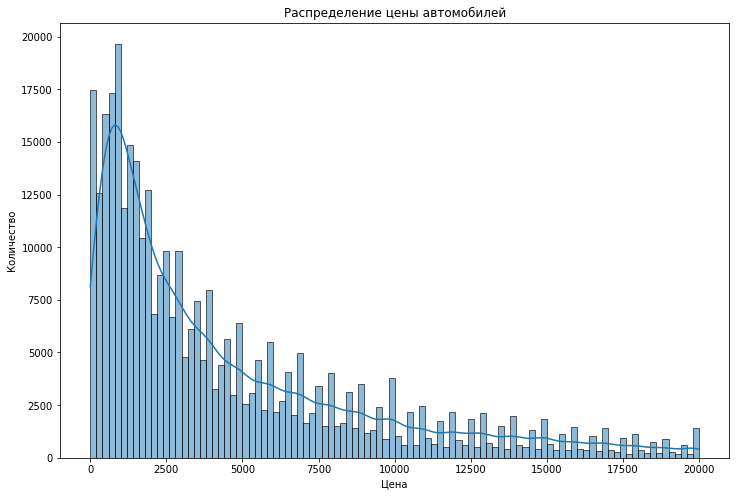

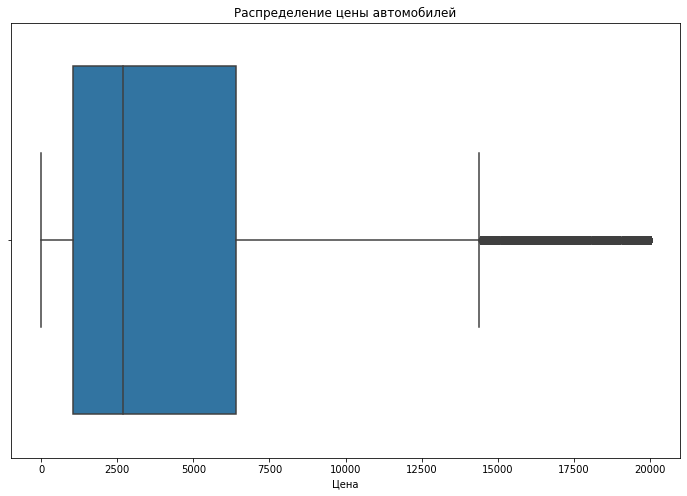

In [33]:
# построим графики
draw_charts(data, 'price', 'Цена', 'Количество', 'Распределение цены автомобилей', 100)

На графике мы видим длинный хвост справа, но такая ситуация вполне реальна, так как есть более дорогие автомобили и их не так много, как автомобилей из средней ценовой категории. Эти данные не будем считать за аномалии и оставим их для обучения модели. 

Но на данном графике очень много автогомобилей с ценой 0, скорее всего это связано с тем, что продавец сознательно не указал цену. Посмотрим, сколько строк с ценой 0 и можно ли как-то подобные строки восстановить.

In [34]:
# проанализируем строки с ценой = 0
data[data['price'] == 0]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32


In [35]:
# Определим, сколько строк имеют цену = 0
print(f'Количество аномальных значений в стоблце price: {round(data[data["price"] == 0].shape[0] / data.shape[0] * 100)}%')

Количество аномальных значений в стоблце price: 3%


Мы получили, что количество аномальных значеий составляет 3%, по таблице выше сложно сказать и восстановить примерные цены на автомобили, поэтому удалим данные значения.

In [36]:
# удаление строк, в которых цена равна 0
data_new = data.loc[data['price'] != 0]

In [37]:
data_new.shape

(343593, 16)

**Проанадизируем столбец registration_year**

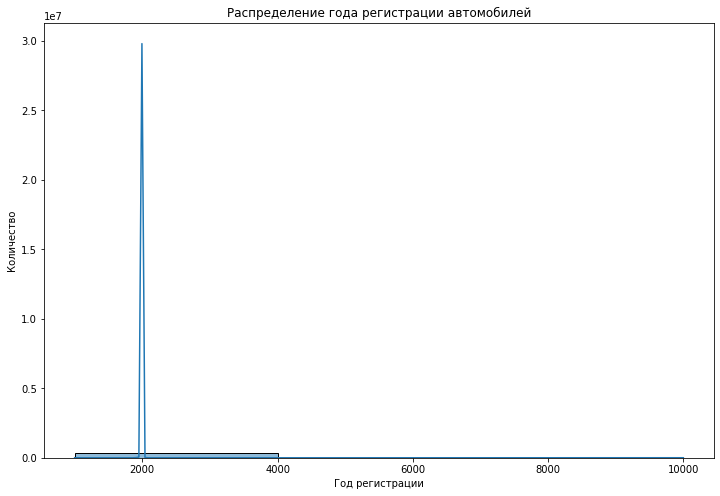

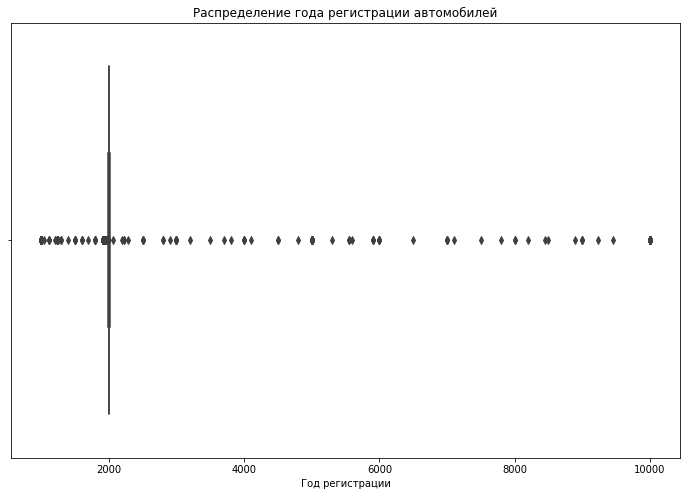

In [38]:
# построим графики
draw_charts(data, 'registration_year', 'Год регистрации', 'Количество', 'Распределение года регистрации автомобилей', 3)

Наши графики не такие информативные, как хотелось бы, но все же видны аномалии. Есть автомобили с годом регистрации значительно меньшим, чем 2000, или наоборот, значительно большим, например 4000. Как известно, первый автомобиль, ставший серийной моделью был запатентован в 1888 году. В нашей базе представлены данные до 2016 года включительно. Посмотрим, какое количество автомобилей не входит в интервал с 1888 по 2016 годы включительно. Возможно, это намеренное неверное указание года регистрации автомобиля, или, напрмер, дозаполнение базы, в которых изначально эти значения не были указаны.

In [39]:
data[data['registration_year'] <= 1888]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16,0,44628,2016-03-20 16:44:37
16062,2016-03-29 23:42:16,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29,0,47166,2016-04-06 10:44:58
18224,2016-03-09 17:49:44,7999,NaN,1500,manual,224,impreza,5000,3,NaN,subaru,NaN,2016-03-09,0,53577,2016-03-15 05:15:17
34332,2016-04-01 06:02:10,450,NaN,1800,NaN,1800,NaN,5000,2,NaN,mitsubishi,no,2016-04-01,0,63322,2016-04-01 09:42:30
38875,2016-03-19 23:54:40,1234,NaN,1234,NaN,26,NaN,5000,1,NaN,trabant,NaN,2016-03-19,0,38518,2016-04-06 03:15:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323443,2016-03-26 20:58:27,30,NaN,1000,NaN,0,NaN,5000,0,NaN,audi,NaN,2016-03-26,0,37574,2016-04-06 12:17:27
325739,2016-03-30 11:36:35,400,NaN,1000,NaN,0,NaN,5000,0,NaN,mercedes_benz,NaN,2016-03-30,0,8060,2016-04-01 06:16:46
340759,2016-04-04 23:55:47,700,NaN,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04,0,86343,2016-04-05 06:44:07
348830,2016-03-22 00:38:15,1,NaN,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-21,0,41472,2016-04-05 14:18:01


In [40]:
data[data['registration_year'] > 2016]['registration_year'].value_counts()

2017    10441
2018     3959
9999       26
2019       25
5000       17
3000        7
6000        5
2500        4
7000        4
4000        3
9000        3
8000        2
5555        2
2222        2
2800        2
4500        2
5911        2
3700        1
3500        1
2900        1
8500        1
4100        1
9450        1
5900        1
6500        1
7100        1
5300        1
7800        1
8888        1
8200        1
9996        1
8455        1
2290        1
2066        1
5600        1
4800        1
3800        1
3200        1
9229        1
2200        1
7500        1
Name: registration_year, dtype: int64

In [41]:
# Определим количество аномальных значений в столбце registration_year
print(f'Количество аномальных значений в стоблце registration_year: {round((data_new[data_new["registration_year"] <= 1888].shape[0] + data_new[data_new["registration_year"] > 2016].shape[0]) / data_new.shape[0] * 100)}%')

Количество аномальных значений в стоблце registration_year: 4%


Да, в данном столбце много аномальных значений, с годами регистрации большими, чем год размещения объявлений. Возможно большое количество машин с годом регистрации 2017 связано с тем, что это новые автомобили и они еще не зарегитрированы. Кроме того, процент этих аномалий составляет 4%, поэтому удалим данные аномалии

In [42]:
# очистим данные от аномальных значений столбца registration_year
data_new = data_new.loc[(data_new['registration_year'] > 1888)&(data_new['registration_year'] <= 2016)]

In [43]:
data_new.shape

(329761, 16)

**Проанализируем столбец Power**

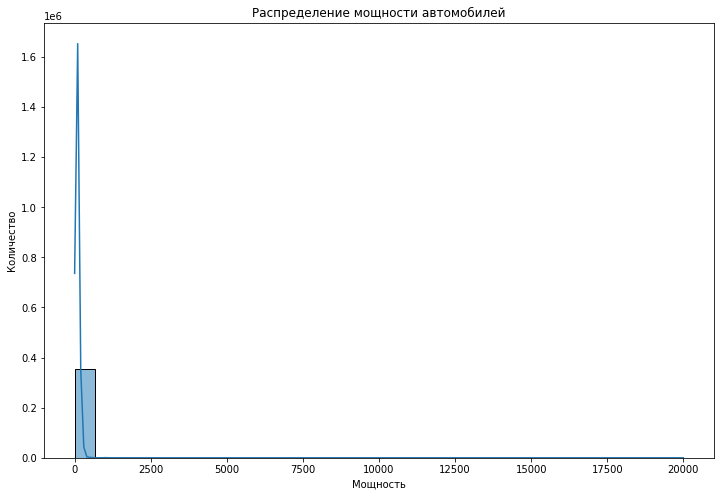

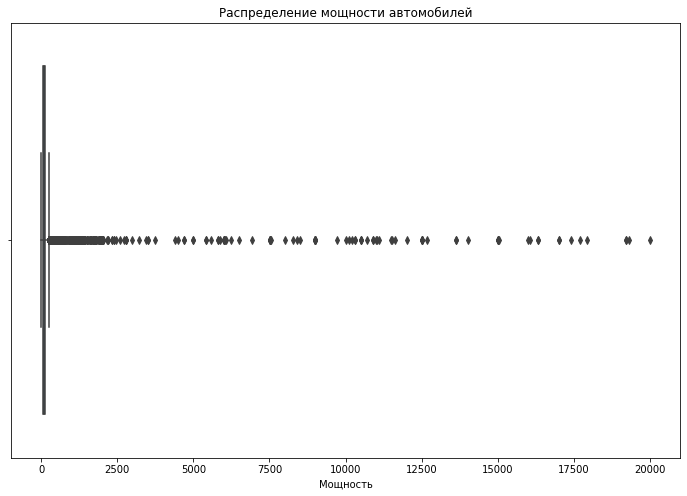

In [44]:
# построим графики
draw_charts(data, 'power', 'Мощность', 'Количество', 'Распределение мощности автомобилей', 30)

В данных присутствуют слишком большие по величине выбросы, поэтому создадим таблицу с мощностью до 1000 л.с., так как более этого значения это редкость

In [45]:
# создадим таблицу power_1000 с мощностью до 1000 л.с.
power_1000 = data_new.loc[data_new['power'] <= 1000]

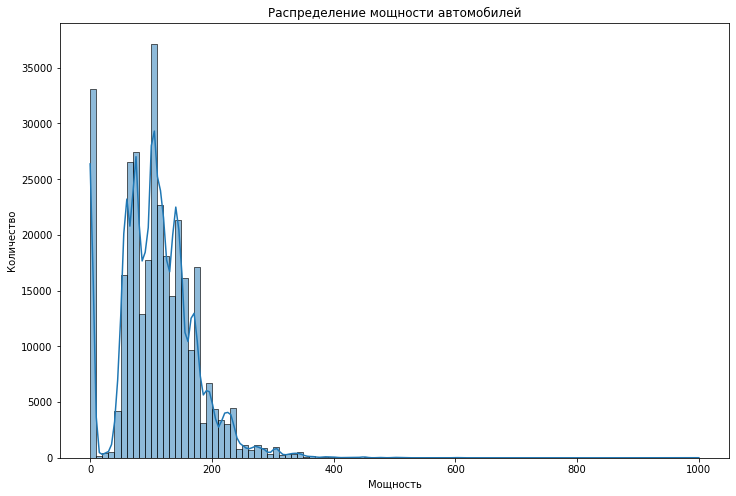

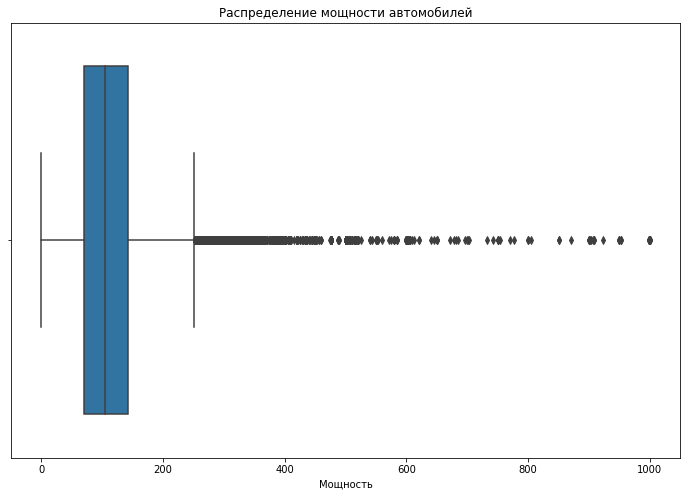

In [46]:
# построим графики таблицы power_1000
draw_charts(power_1000, 'power', 'Мощность', 'Количество', 'Распределение мощности автомобилей', 100)

Как видим, здесь так же много значений мощности раной 0, возможно, это уже какие-то раритетные автомобили, которые уже не на ходу, а также аномальные значения начинаются при мощности более 600 л.с.

In [47]:
# посмотрим на строки, в которых power = 0
data[data['power'] == 0]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354338,2016-03-31 19:52:33,180,NaN,1995,NaN,0,NaN,125000,3,petrol,opel,NaN,2016-03-31,0,41470,2016-04-06 14:18:04
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07,0,61169,2016-03-08 21:28:38
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21,0,2694,2016-03-21 10:42:49


In [48]:
# Определим количество аномальных значений в столбце power
print(f'Количество аномальных значений в стоблце power: {round((data_new[data_new["power"] < 30].shape[0] + data_new[data_new["power"] > 600].shape[0]) / data_new.shape[0] * 100)}%')

Количество аномальных значений в стоблце power: 10%


В целом наша теория не подтвердилась, поэтому удалим данные, в которых мощность менее 30 л.с. и более 600 л.с., процентное значение аномальных знаений составляет 10.

In [49]:
# очистим данные от аномальных значений столбца power
data_new = data_new.loc[(data_new['power'] > 30)&(data_new['power'] <= 600)]

In [50]:
data_new.shape

(295698, 16)

**Исследуем столбец registration_month**

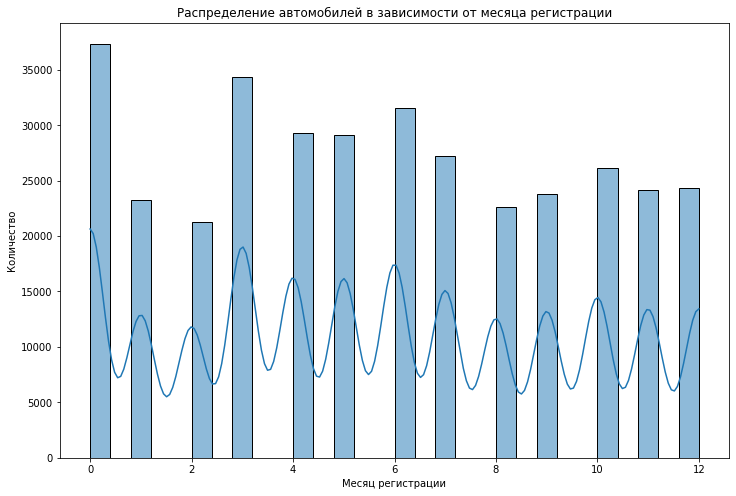

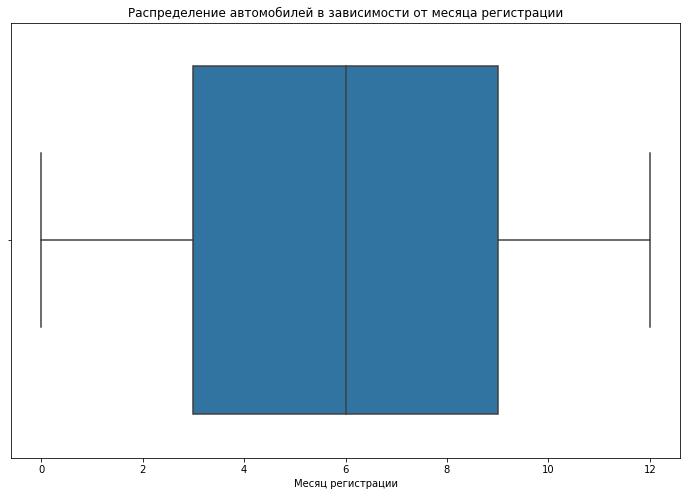

In [51]:
# построим графики
draw_charts(data, 'registration_month', 'Месяц регистрации', 'Количество', 'Распределение автомобилей в зависимости от месяца регистрации', 30)

Как видим, очень много значений с месяце регистрации 0. Скорее всего в изначальных данных этот параметр не указывался и это было автозаполнения пропущенных значений. Определим их долю.

In [52]:
# Определим количество аномальных значений в столбце registration_month
print(f'Количество аномальных значений в стоблце power: {round(data_new[data_new["registration_month"] == 0].shape[0] / data_new.shape[0] * 100)}%')

Количество аномальных значений в стоблце power: 6%


Таких данных 6%. Мое мнеение, что эти данные удалять не надо и их модно оставить как есть, так как скорее всего по данным строкам нет заполненой информации.

В данном пункте мы провели исследовательский анализ данных, отсекли некоторые аномальные значения. В следующем пункте проведем подготовку данных: еще раз обратим внимание на пропуски, признаки и сформируем данные, на основании которых можно проводить обучение моделей.

### Подготовка данных

В данном пункте проведем предобработку данных:

1) заменим пропуски в столбцах

2) удалим ненужные столбцы

3) проведем перекодировку данных

4) разделим данные на выборки

In [53]:
# посмотрим еще раз на пропуски, так как была обработка данных
missing_values_percentage(data_new)

,index,Missing Values Count,Missing Values %
11,not_repaired,42734,14.45
9,fuel_type,15459,5.23
2,vehicle_type,10982,3.71
6,model,10932,3.70
4,gearbox,5313,1.80


In [54]:
# посмотрим значения в столбце gearbox
data_new['gearbox'].value_counts()

manual    231621
auto       58764
Name: gearbox, dtype: int64

Как видим, в данном столбце всего две коробки передачи. Скорее всего по имеющисся у нас данным будет слодно восстановить с высокой точностью, в каком случае какая коробка передач, так как у одной и то же модели могут быть разные коробки передач. Кроме того, могут быть гибридные автомобили. Поэтому пропуски в данной строке заполним на 'other'

In [55]:
# заполнение пропусков в столбце gearbox
data_new['gearbox'] = data_new['gearbox'].fillna('other')

In [56]:
# еще раз проверим столбец gearbox
data_new['gearbox'].value_counts()

manual    231621
auto       58764
other       5313
Name: gearbox, dtype: int64

Пропуски в других столбцах заменим на unknown, так как по имеющемуся разнообразию данных сложно восстановить доставерно, какая модель, тип топлива был у автомобиля, ремонтировалась она или нет

In [57]:
# заполним пропуски в столбцах vehicle_type, model, fuel_type, not_repaired
list_name = ['vehicle_type', 'model', 'fuel_type', 'not_repaired']
for name in list_name:
    data_new[name] = data_new[name].fillna('unknown')

In [58]:
data_new.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Все данные заполнены. Далее удалим столбцы, которые на мой взгляд не имеют значения для обучения модели. Мы удалим следующие столбцы:

1) date_crawled - нам не нужна информация о дате скачивания анкеты из базы, в ней нет какой-то нужно для обучения модели информации

2) numbers_of_pictures - как мы видели выше во всех строках отсутствуют картинки, поэтому особого смысла в этом столбце нет

3) postal_code - так же удаляем, так как какого значения в обучении модели предсказания стоимости автомобиля по данному признаку нет

4) last_seen - нам также не важно, когда в последний раз была активность пользователя


In [59]:
# удаляем столбцы data_crawled, number_of_pictures, postal_code, last_seen, date_created
data_new.drop(columns=['date_crawled', 'number_of_pictures', 'postal_code', 'last_seen', 'date_created'], inplace=True)

In [60]:
# проверим, удалились ли указанные столбцы
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295698 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               295698 non-null  int64 
 1   vehicle_type        295698 non-null  object
 2   registration_year   295698 non-null  int64 
 3   gearbox             295698 non-null  object
 4   power               295698 non-null  int64 
 5   model               295698 non-null  object
 6   kilometer           295698 non-null  int64 
 7   registration_month  295698 non-null  int64 
 8   fuel_type           295698 non-null  object
 9   brand               295698 non-null  object
 10  not_repaired        295698 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.1+ MB


Удаление столбцов мы осуществили. ПРиступим к кодировке категориальных признаков. КАтегориальные признаки находятся в стобцах:
vehicle_type, model, fuel_type, brand,. Данные столбцы мы преобразуем методом OrdinalEncoder. Столбцы gearbox и not_repaired удобнее преобразовать методом OHE.

In [61]:
# произведем перекодирование столбцов vehicle_type, model, fuel_type, brand методом OrdinalEncoder()
ce_ordinal = ce.OrdinalEncoder(cols = ['vehicle_type', 'model', 'fuel_type', 'brand'])
data_new_ordinal = ce_ordinal.fit_transform(data_new)

In [62]:
# произведем перекодирование столбцов gearbox и not_repaired методом OHE
data_new_ordinal['gearbox'] = pd.get_dummies(data_new_ordinal['gearbox'], drop_first=True)
data_new_ordinal['not_repaired'] = pd.get_dummies(data_new_ordinal['not_repaired'], drop_first=True)

In [63]:
# как видим все категориальные данные приведены к числовым
data_new_ordinal.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
1,18300,1,2011,1,190,1,125000,5,1,1,0
2,9800,2,2004,0,163,2,125000,8,1,2,1
3,1500,3,2001,1,75,3,150000,6,2,3,0
4,3600,3,2008,1,69,4,90000,7,1,4,0
5,650,4,1995,1,102,5,150000,10,2,5,0


In [64]:
data_new_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295698 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   price               295698 non-null  int64
 1   vehicle_type        295698 non-null  int64
 2   registration_year   295698 non-null  int64
 3   gearbox             295698 non-null  uint8
 4   power               295698 non-null  int64
 5   model               295698 non-null  int64
 6   kilometer           295698 non-null  int64
 7   registration_month  295698 non-null  int64
 8   fuel_type           295698 non-null  int64
 9   brand               295698 non-null  int64
 10  not_repaired        295698 non-null  uint8
dtypes: int64(9), uint8(2)
memory usage: 23.1 MB


### Разделение выборки на тренировочную, валидационную и учебную

В данном разделе разделим нашу выборку на тренирововчную, валидационную и тестовую

In [65]:
# выделим целевой признак, по условию задачи это столбец price
features = data_new_ordinal.drop('price', axis=1)
target = data_new_ordinal['price']

In [66]:
# проведем масштабирование данных
#scaler = StandardScaler()
#features = scaler.fit_transform(features, target)

In [67]:
# код ревьюера
pd.DataFrame(features).head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
1,1,2011,1,190,1,125000,5,1,1,0
2,2,2004,0,163,2,125000,8,1,2,1
3,3,2001,1,75,3,150000,6,2,3,0
4,3,2008,1,69,4,90000,7,1,4,0
5,4,1995,1,102,5,150000,10,2,5,0


Обычно для разделения выборки используют соотношение 3:1:1 (тренировочная, валидационная и тестовая выборки соответственно). Разделим наши данные в соответствии с указанными пропорциями

In [68]:
# для начала выдели тренировочную и промежуточную выборки, затем промежуточную выборку разделим на тренировочную и валидационную
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

In [69]:
# выведем размеры получившихся выборок
print('Размеры наборов данных:')
print('features_train: ', features_train.shape, 'target_train: ', target_train.shape)
print('features_valid: ', features_valid.shape, 'target_valid: ', target_valid.shape)
print('features_test:  ', features_test.shape, 'target_test: ', target_test.shape)

Размеры наборов данных:
features_train:  (177418, 10) target_train:  (177418,)
features_valid:  (59140, 10) target_valid:  (59140,)
features_test:   (59140, 10) target_test:  (59140,)


In [70]:
# проверим соответствие размеров выборок общему количеству строк исходного файла
print(features_train.shape[0] + features_valid.shape[0] + features_test.shape[0] == data_new_ordinal.shape[0])
print(target_train.shape[0] + target_valid.shape[0] + target_test.shape[0] == data_new_ordinal.shape[0])

True
True


**Доработка**

In [71]:
# проведем масштабирование данных
numeric = ['registration_year', 'power', 'kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_91/813844616.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_91/813844616.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [72]:
# для train
pd.DataFrame(features_train).head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
228,4,0.178489,1,-0.852875,3,-0.781482,9,2,3,0
52458,7,1.109623,0,0.355559,3,-0.781482,9,1,3,0
290136,6,-0.287079,1,-0.350910,19,0.587301,9,1,3,0
268407,6,0.333678,1,-0.443866,86,0.587301,6,7,15,0
257181,1,-1.373402,1,-0.090632,183,0.587301,7,2,15,0


In [73]:
# для valid
pd.DataFrame(features_valid).head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
111586,7,-0.442268,0,-0.350910,19,0.587301,1,3,3,0
272718,6,0.799245,1,-0.852875,225,-1.055238,1,1,14,0
67056,7,-0.752646,1,0.076690,9,0.587301,11,2,3,0
4922,3,-0.597457,1,-1.224700,1,0.587301,0,2,3,0
50729,4,-0.442268,0,-0.090632,73,-0.097090,3,2,15,0


In [74]:
# для test
pd.DataFrame(features_test).head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
267424,3,-0.597457,1,-0.090632,93,0.587301,4,2,3,0
13508,3,-0.752646,1,-0.852875,30,0.587301,12,2,7,0
228898,3,-0.131889,1,-1.168927,12,-0.097090,0,2,10,1
119162,8,2.040757,0,-1.224700,3,0.587301,7,3,3,0
297472,4,0.644056,1,0.225420,158,0.587301,2,2,28,0


Данный подготовлены для обучения моделей.

### Вывод

В ходе выполнения данного раздела было сделано следующее:

1) произведи предварительный обзор данных, познакомились с набором данных, подробно рассмотрели все столбцы, выявили наличие дубликатов, пропусков, аномалий

2) исследовали аномалии в столбцах: price, regostration_year, power, registration_month. В некоторых случаях данные были очищены от аномалий.

3) во всех стоблцах где были пропуски, эти пропуски были заполнены

4) категориальные признаки были преобразованы методами OrdinalEncoder и OHE

5) набор данных был масштабирован и разделен на тренировочную, валидационную и тестовую выборки.

## Обучение моделей

Для автоматизации дальнейших вычислений на различтных моделях напишем функцию для вычисления RMSE модели, оценку кросс-валидации и скорости обучения модели.

In [75]:
# напишем функцию для расчета RMSE модели
def RMSE(target,predictions):
    """
    Вычисление RMSE модели
    
    return: RMSE модели
    
    """
    
    MSE = mean_squared_error(target, predictions, squared=False)
    
    return MSE

RMSE_score = make_scorer(RMSE, greater_is_better=False)

В функции ниже буду использовать стнадартные модуль time() Python для определения хараетеристик времени работы.

In [76]:
def best_model(model, params, features_train, target_train, features_test, target_test):
    """
    Функция определения времени обучения, времени предсказания и RMSE модели
    
    return: время обучения, время предсказания, RMSE модели
    """
    
    
    grid = GridSearchCV(model, param_grid = params, cv=5,
                                            scoring = RMSE_score, n_jobs=-1)
    start_time = time.time()
    grid.fit(features_train,target_train)
    first_time = time.time() - start_time
    start_time = time.time()
    predict = grid.predict(features_test)
    second_time = time.time() - start_time
    
    return first_time, second_time, RMSE(target_test, predict)

Далее обучим следующие модели:

1) LGBM модель

2) CatBoost модель

3) модель RandomForest

4) модель DecisionTree

5) константную модель

**Обучение LGBM модели**

In [77]:
# зададим параметры
lgbm_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [15, 30],
    'num_leaves': [10, 20, 31],
    'learning_rate': [0.1]
}

lgbm_model = LGBMRegressor(random_state=12345)

In [78]:
# обучим модель
lgbm = best_model(lgbm_model, lgbm_params, features_train, target_train, features_valid, target_valid)

**Обучение CatBoost модели**

In [79]:
# зададим параметры
catboost_params = {
    'learning_rate': [0.1],
    'iterations': [10, 50, 100],
    'max_depth': [1, 10]
}

catboost_model = CatBoostRegressor(random_state=12345, silent=True)

In [80]:
# обучим модель
cat_boost = best_model(catboost_model, catboost_params, features_train, target_train, features_valid, target_valid)

**Обучение модели RandomForest**

In [81]:
# определим параметры
random_forest_model = RandomForestRegressor(random_state=12345)
forest_params = {'n_estimators': range(10, 51, 10), 'max_depth': range (1, 10)}

In [82]:
# обучим модель
random_forest = best_model(random_forest_model, forest_params, features_train, target_train, features_valid, target_valid)

**Обучение модели DecisionTree**

In [83]:
# зададим параметры и обучим подель
decision_tree_model = DecisionTreeRegressor(random_state=12345)
tree_params = {'max_depth': range (1, 10)}
decision_tree = best_model(decision_tree_model, tree_params, features_train, target_train, features_valid, target_valid)

**Обучение константной модели**

In [84]:
# обучим констунтную модель и определим ее RMSE
constant_model = DummyRegressor(strategy='mean')
constant_model.fit(features_train, target_train)
constant_predict = constant_model.predict(features_valid)
RMSE(target_valid, constant_predict)

4619.711133023127

### Вывод

В данном раздели мы обучили следующие модели:

1) LGBM модель

2) CatBoost модель

3) модель RendomForest

4) модель DecisionTree

5) константную модель

В следующем разделе сравним время обучения моделей, время предсказания и RMSE

## Анализ моделей

Для наглядности в данном разделе объеденим все данные в одну таблицу

In [85]:
# создадим таблицу models
models = pd.DataFrame([lgbm, cat_boost, decision_tree, random_forest],
                     columns=['Время обучения', 'Время предсказания', 'RMSE'],
                      index=['LGBM модель', 'CatBoost модель', 'DecisionTree модель', 'RandomForest модель']
                     )

In [86]:
models

,Время обучения,Время предсказания,RMSE
LGBM модель,6877.138794,0.494199,1741.769505
CatBoost модель,60.827611,0.026787,1741.502976
DecisionTree модель,9.332985,0.008104,2053.725904
RandomForest модель,813.424441,0.242260,1965.132166


При обучении модели на тренировочной выберке и ее проверке на валидацинной, мы получили с ледующие результаты:

1) модель с наилучшей RMSE - CatBoost модель

2) модель с наиличшим временем обучени и предсказания - DecisionTree модель, но данная модель модель дает ошибку выше, чем CatBoost модель и LGBM модель

3) наихудшее время обучения модели у RandomForest модели

4) все модели адекватные, так как RMSE всех моделей значительно ниже RMSE константной модели.

Проверим наши модели на тестовой выборке

In [87]:
# зададим параметры
lgbm_params_test = {
    'n_estimators': [10, 50, 100],
    'max_depth': [15, 30],
    'num_leaves': [10, 20, 31],
    'learning_rate': [0.1]
}

lgbm_model_test = LGBMRegressor(random_state=12345)
lgbm_test = best_model(lgbm_model_test, lgbm_params_test, features_train, target_train, features_test, target_test)

In [88]:
# зададим параметры
catboost_params_test = {
    'learning_rate': [0.1],
    'iterations': [10, 50, 100],
    'max_depth': [1, 10]
}

catboost_model_test = CatBoostRegressor(random_state=12345, silent=True)
cat_boost_test = best_model(catboost_model_test, catboost_params_test, features_train, target_train, features_test, target_test)

In [89]:
# определим параметры
random_forest_model_test = RandomForestRegressor(random_state=12345)
forest_params_test = {'n_estimators': range(10, 51, 10), 'max_depth': range (1, 10)}
random_forest_test = best_model(random_forest_model_test, forest_params_test, features_train, target_train, features_test, target_test)

In [90]:
# зададим параметры и обучим подель
decision_tree_model_test = DecisionTreeRegressor(random_state=12345)
tree_params_test = {'max_depth': range (1, 10)}
decision_tree_test = best_model(decision_tree_model_test, tree_params_test, features_train, target_train, features_test, target_test)

In [91]:
# обучим констунтную модель и определим ее RMSE
constant_model_test = DummyRegressor(strategy='mean')
constant_model_test.fit(features_train, target_train)
constant_predict_test = constant_model_test.predict(features_test)
RMSE(target_test, constant_predict_test)

4612.950140603976

In [92]:
# создадим таблицу models
models_test = pd.DataFrame([lgbm_test, cat_boost_test, decision_tree_test, random_forest_test],
                     columns=['Время обучения', 'Время предсказания', 'RMSE'],
                      index=['LGBM модель', 'CatBoost модель', 'DecisionTree модель', 'RandomForest модель']
                     )

In [93]:
models_test

,Время обучения,Время предсказания,RMSE
LGBM модель,2579.098989,0.417215,1742.248670
CatBoost модель,61.154863,0.025344,1738.951167
DecisionTree модель,8.576037,0.008298,2059.867482
RandomForest модель,816.985621,0.240216,1969.981267


При тестировании моделей, мы получили схожие данные, но по времени все модели стали обучаться чуть дольше, зато RMSE стала немного меньше. И как и при использовании валидационной выборки, данные модели адекватны, так как их значения значительно меньше RMSE, расчитанной на константной модели.

### Вывод

В ходе выполнения данного раздела мы проанализировали время обучения моделей, время предсказания, а также RMSE моделей. В результате чего мы плучили следующее:

1) модель с наилучшей RMSE - CatBoost модель

2) модель с наиличшим временем обучени и предсказания - DecisionTree модель, но данная модель модель дает ошибку выше, чем CatBoost модель и LGBM модель

3) наихудшее время обучения модели у RandomForest модели

4) все модели адекватные, так как RMSE всех моделей значительно ниже RMSE константной модели.

Если сравнивать тестирование моделей, то мы получим примерно такие же показатели.

## Общий вывод

В ходе выполнения данной работы мы: 

1) произвели предварительный обзор данных, познакомились с набором данных, подробно рассмотрели все столбцы, выявили наличие дубликатов, пропусков, аномалий. Исследовали аномалии в столбцах: price, regostration_year, power, registration_month. В некоторых случаях данные были очищены от аномалий. Во всех стоблцах где были пропуски, эти пропуски были заполнены. Категориальные признаки были преобразованы методами OrdinalEncoder и OHE. Набор данных был масштабирован и разделен на тренировочную, валидационную и тестовую выборки.

2) мы обучили следующие модели: LGBM модель, CatBoost модель, модель RendomForest, модель DecisionTree, константную модель

3) проанализировали время обучения моделей, время предсказания, а также RMSE моделей. В результате чего мы плучили следующее:

    - модель с наилучшей RMSE - CatBoost модель

    - модель с наиличшим временем обучени и предсказания - DecisionTree модель, но данная модель модель дает ошибку выше, чем CatBoost модель и LGBM модель

    - наихудшее время обучения модели у RandomForest модели

    - все модели адекватные, так как RMSE всех моделей значительно ниже RMSE константной модели.

Если сравнивать тестирование моделей, то мы получим примерно такие же показатели.

Таким образом, исходя из требований заказчика, для которого важны: качество предсказания; скорость предсказания; время обучения, мы можем порекомендовать CatBoost модель, так как она имеет наилучшую метрику RMSE - 1741, при относительно небольшом времени обучении - 49.7 и предсказания - 0.14 (модели LGBM имеет схожую метрику - 1743, но при этом время ее обучения хуже в 3-4 раза, и на приняте решения она тратит в два раза больше времени, модель DecisionTree при быстрой скорости обучения - 7.57 и предсказания - 0.005 имееют наихудшую метрику RMSE - 2060, модель RandomForest обучается в 15 раз дольше, принимает решения по времени так же, но качесвто метрики RMSE намного хуже).